In [1]:
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from src.data.make_dataset import reduce_mem_usage

In [2]:
def split_column_types(column_types):
    def is_parse_date(it):
        return it == np.datetime64
    def is_dtype(it):
        try:
            np.dtype(it)
            return not is_parse_date(it)
        except:
            return False
    def is_converter(it):
        return not is_dtype(it) and not is_parse_date(it)
    dtype = {k: v for k, v in column_types.items() if is_dtype(v)}
    parse_dates = [k for k, v in column_types.items() if is_parse_date(v)]
    converters = {k: v for k, v in column_types.items() if is_converter(v)}
    return dtype, parse_dates, converters

def load_site_csv(filepath_or_buffer):
    column_types = {
        "site_id": np.uint8,
        "timezone": pytz.timezone,
        "country_code": np.object,
        "location": np.object,
    }
    dtype, parse_dates, converters = split_column_types(column_types)
    return pd.read_csv(filepath_or_buffer, delimiter=";", dtype=dtype, parse_dates=parse_dates, converters=converters)

def load_weather_csv(filepath_or_buffer):
    column_types = {
        "site_id": np.uint8,
        "timestamp": np.datetime64,
        "air_temperature": np.float16,
        "cloud_coverage": np.float16,
        "dew_temperature": np.float16,
        "precip_depth_1_hr": np.float16,
        "sea_level_pressure": np.float16,
        "wind_direction": np.float16,
        "wind_speed": np.float16,
    }
    dtype, parse_dates, converters = split_column_types(column_types)
    return pd.read_csv(filepath_or_buffer, dtype=dtype, parse_dates=parse_dates, converters=converters)

input_file_path = "../data/raw"
train_df = pd.read_csv(input_file_path + "/train.csv")

site_df = load_site_csv("../data/external/site_info.csv")
weather_df = load_weather_csv(input_file_path + "/weather_train.csv")
weather_df = weather_df.merge(site_df, on="site_id", how="left")

def convert_time_zone(dt, from_tz=pytz.utc, to_tz=pytz.utc):
    return dt.tz_localize(from_tz).tz_convert(to_tz).tz_localize(None)

weather_df["local timestamp"] = weather_df.apply(lambda row: convert_time_zone(row["timestamp"], to_tz=row["timezone"]), axis=1)

building_df = pd.read_csv(input_file_path + "/building_metadata.csv")
train_df = reduce_mem_usage(train_df)
building_df = reduce_mem_usage(building_df)
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df = train_df.merge(building_df, on = "building_id")

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [3]:
train_df["hour"] = train_df["timestamp"].dt.hour
weather_df["hour"] = weather_df["timestamp"].dt.hour
weather_df["local hour"] = weather_df["local timestamp"].dt.hour

In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,hour
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,0
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN,1
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN,2
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN,3
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN,4


In [5]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timezone,country_code,location,local timestamp,hour,local hour
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000,US/Eastern,US,"Orlando, FL",2015-12-31 19:00:00,0,19
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000,US/Eastern,US,"Orlando, FL",2015-12-31 20:00:00,1,20
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,US/Eastern,US,"Orlando, FL",2015-12-31 21:00:00,2,21
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,US/Eastern,US,"Orlando, FL",2015-12-31 22:00:00,3,22
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,US/Eastern,US,"Orlando, FL",2015-12-31 23:00:00,4,23


In [6]:
meter_names = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
train_df["meter"] = train_df["meter"].map(meter_names)

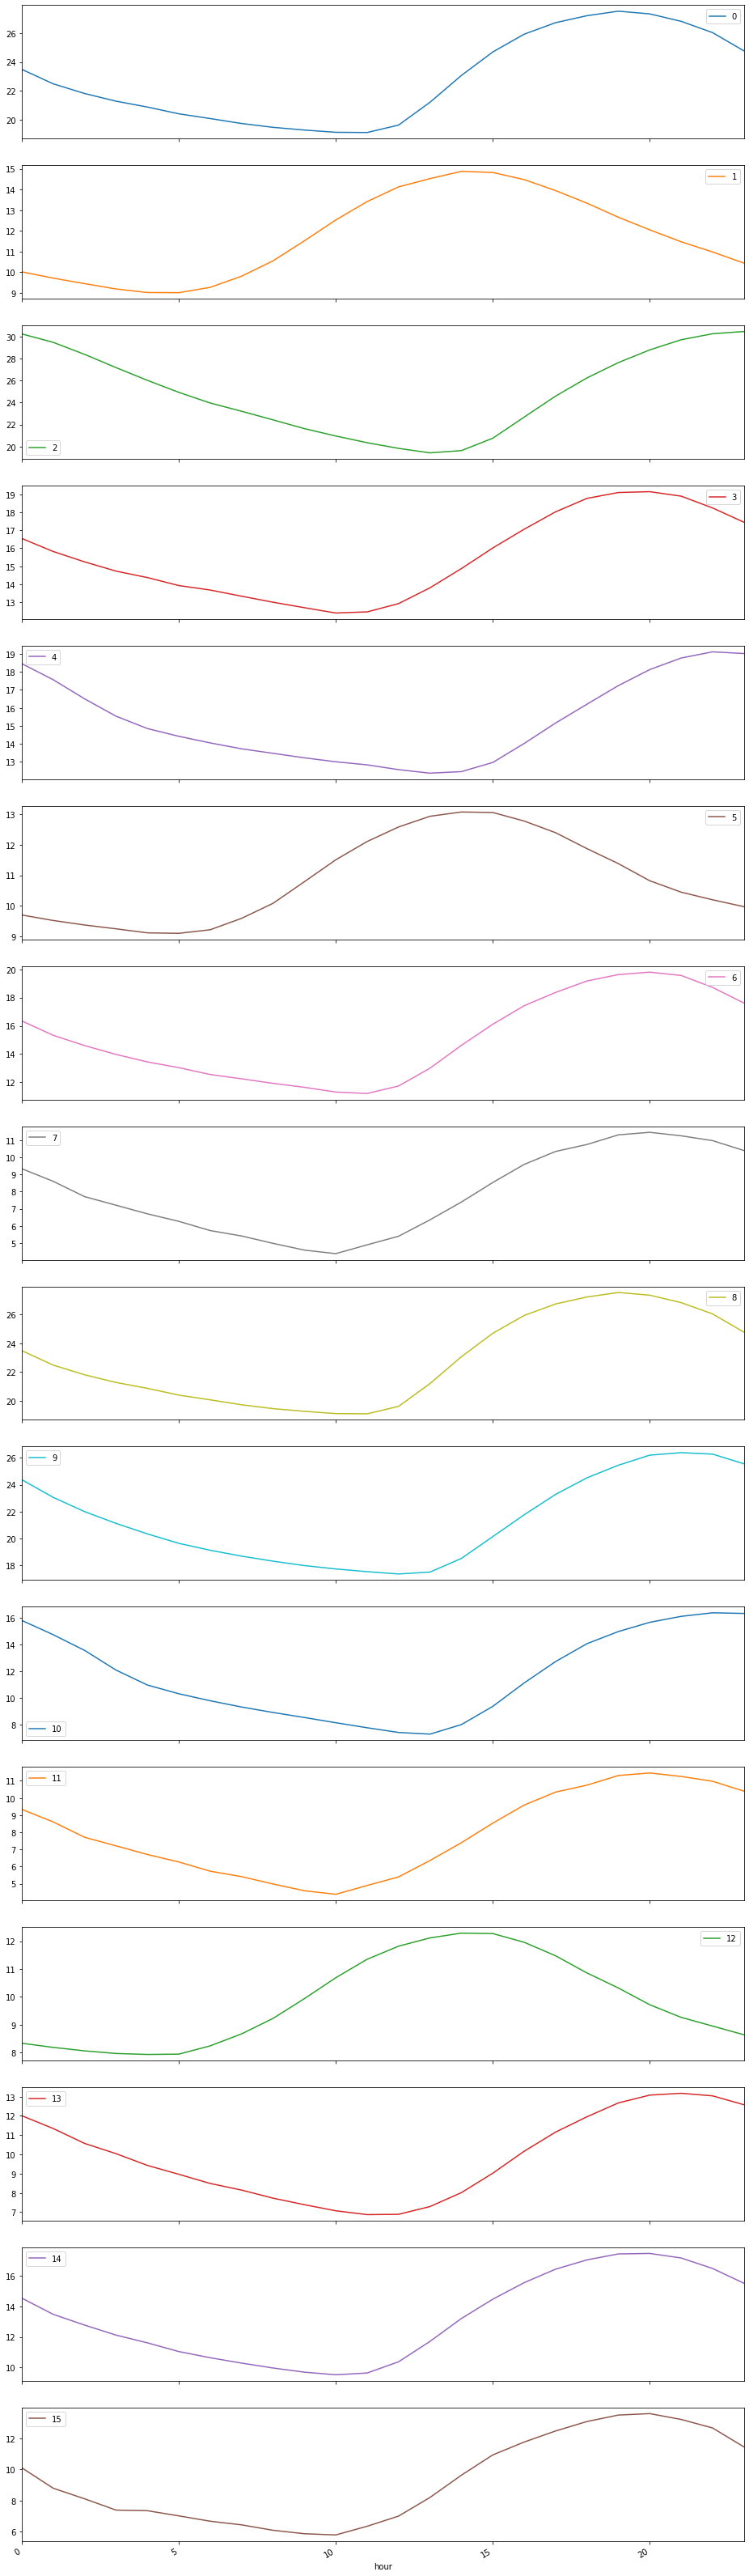

In [7]:
my_plot = weather_df.groupby(["hour", "site_id"])["air_temperature"].mean().unstack().plot(subplots=True, sort_columns=True, figsize=(16,64))

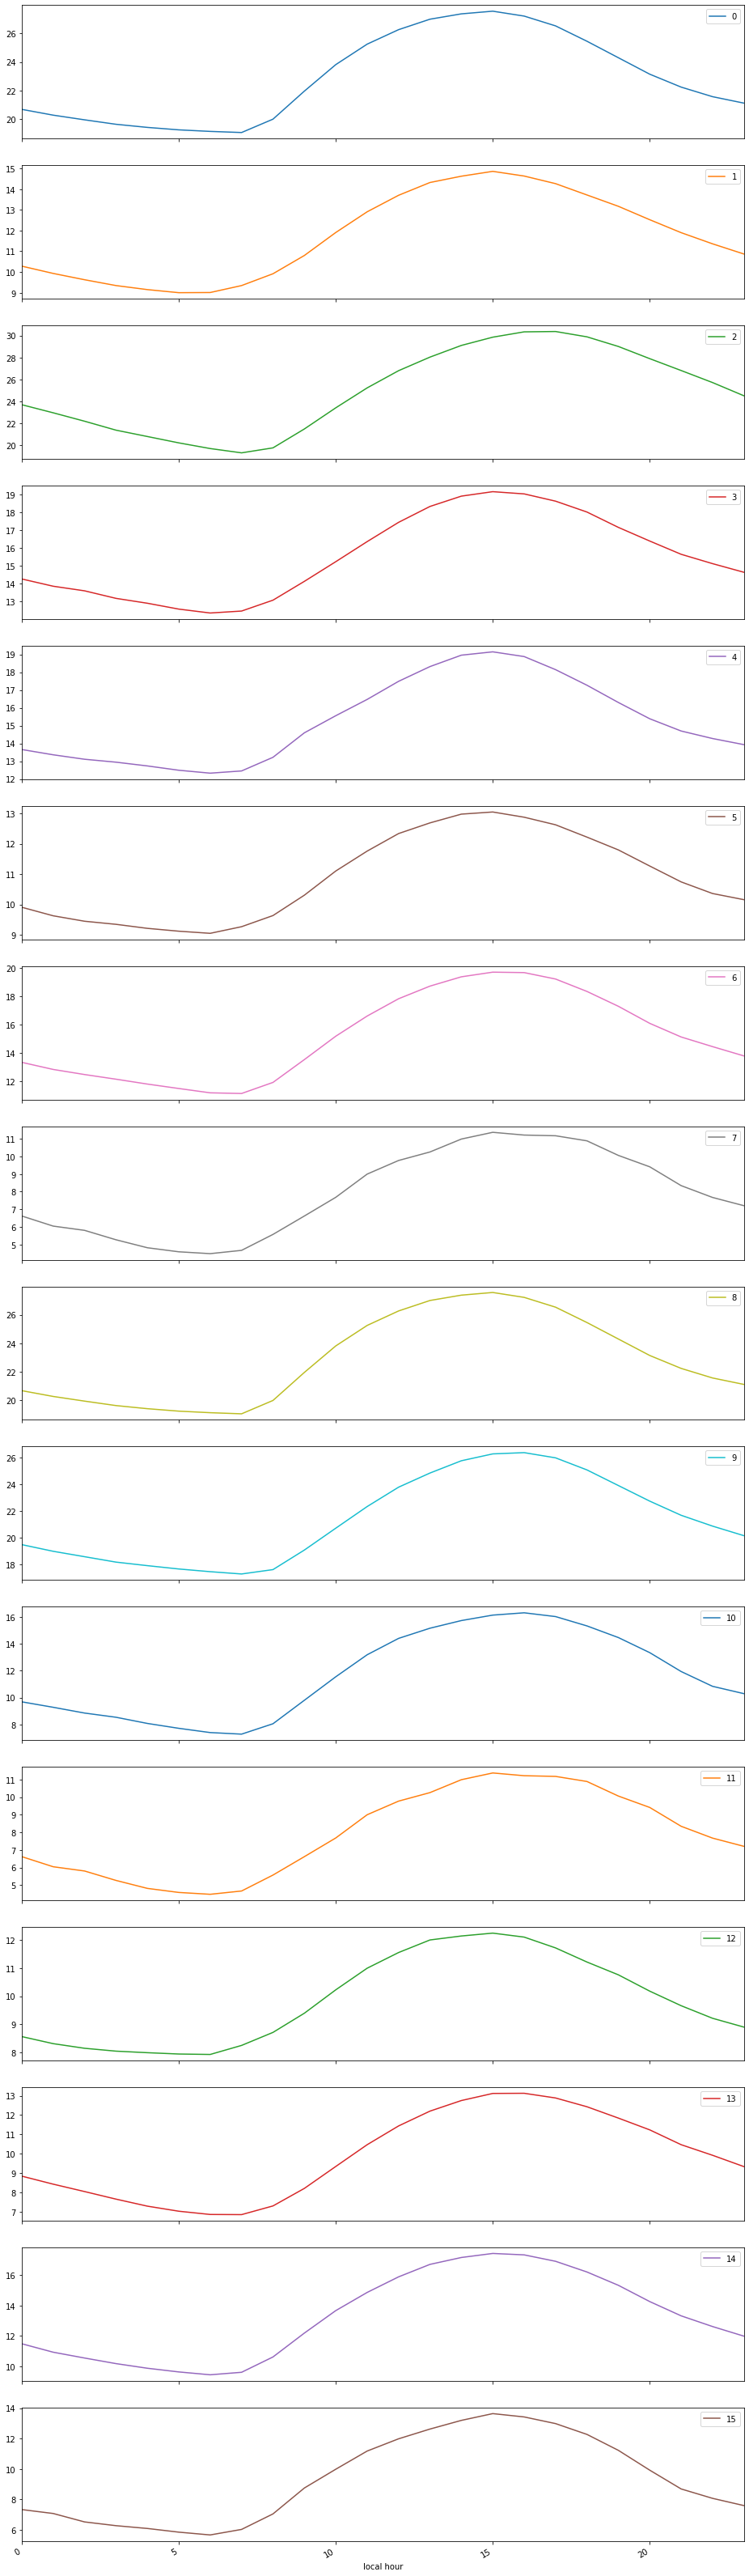

In [8]:
my_plot = weather_df.groupby(["local hour", "site_id"])["air_temperature"].mean().unstack().plot(subplots=True, sort_columns=True, figsize=(16,64))

In [9]:
def relativize(value, min, max):
    return (value-min) / (max-min)

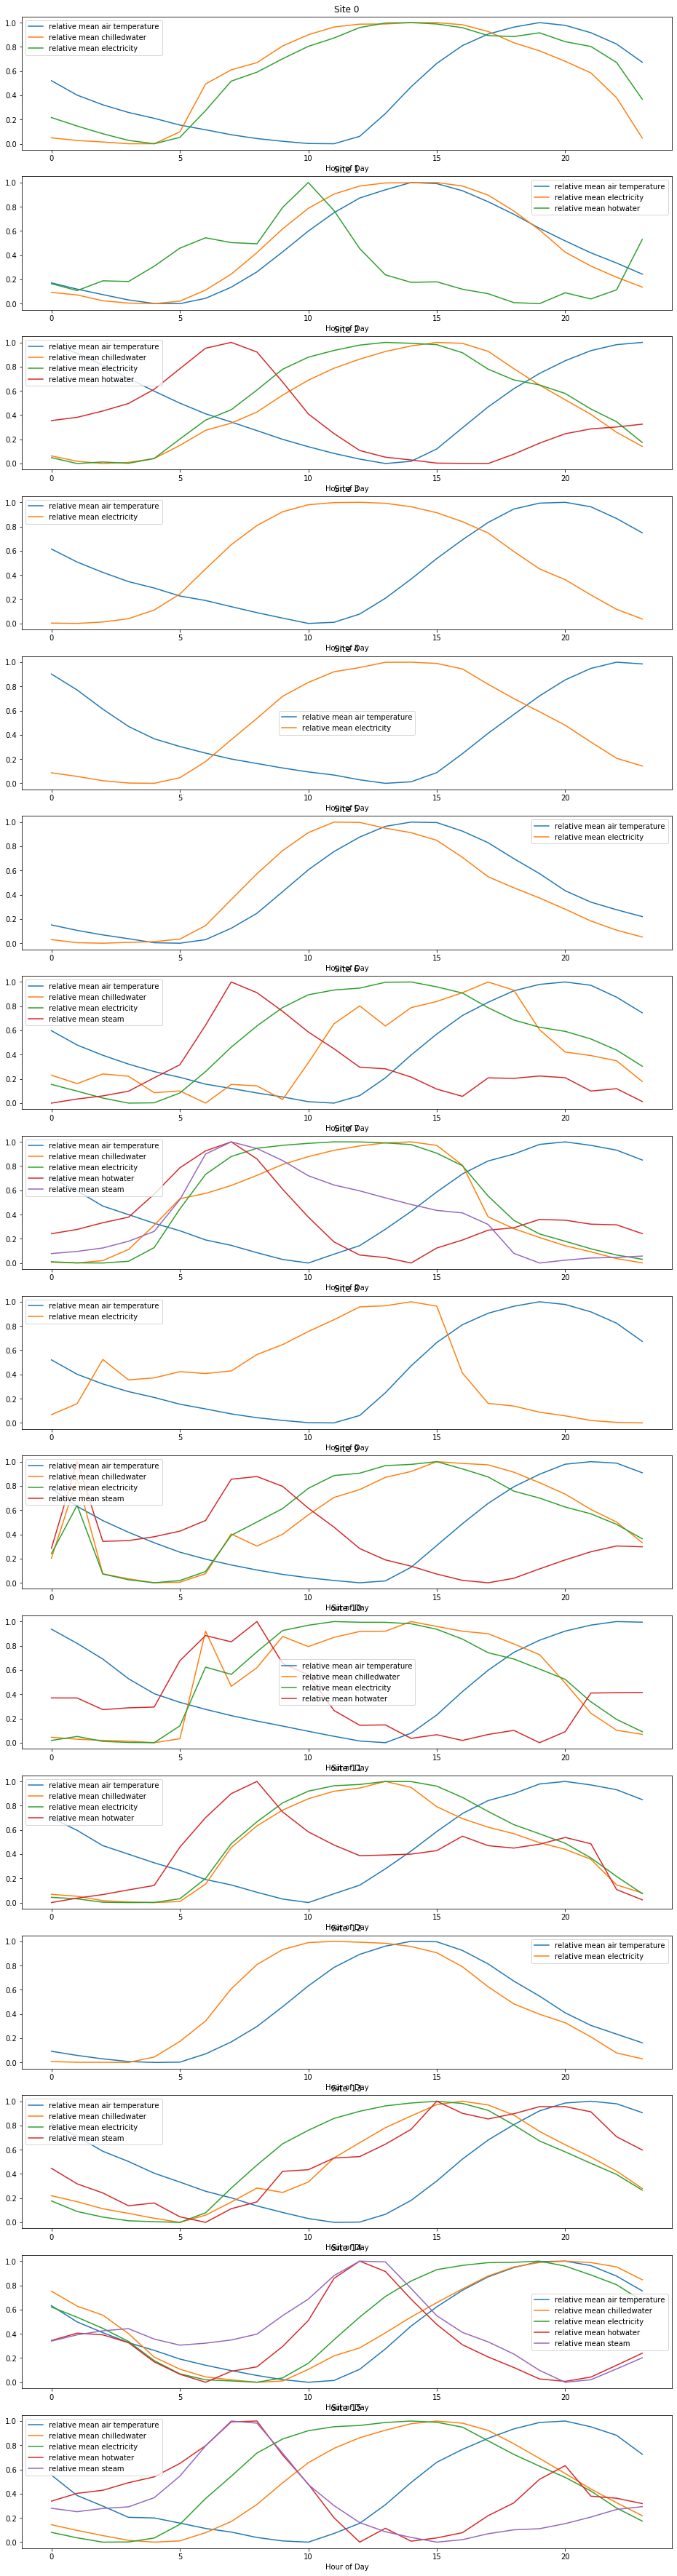

In [10]:
site_count = train_df["site_id"].unique().size
fig, axs = plt.subplots(figsize=(16,64), nrows=site_count)
for (site_id, train_per_site), (site_id, weather_per_site), ax in zip(train_df.groupby(["site_id"]), weather_df.groupby(["site_id"]), axs.flatten()):
    ax.set_title('Site %d'%site_id)
    ax.set_xlabel('Hour of Day')
    mean_air_temperature = weather_per_site.groupby(["hour"])["air_temperature"].mean()
    ax.plot(relativize(mean_air_temperature, mean_air_temperature.min(), mean_air_temperature.max()), label="relative mean air temperature")
    for meter, per_meter in train_per_site.groupby(["meter"]):
        mean_meter_reading = per_meter.groupby(["hour"])["meter_reading"].mean()
        ax.plot(relativize(mean_meter_reading, mean_meter_reading.min(), mean_meter_reading.max()), label="relative mean " + str(meter))
    ax.legend()

plt.show()

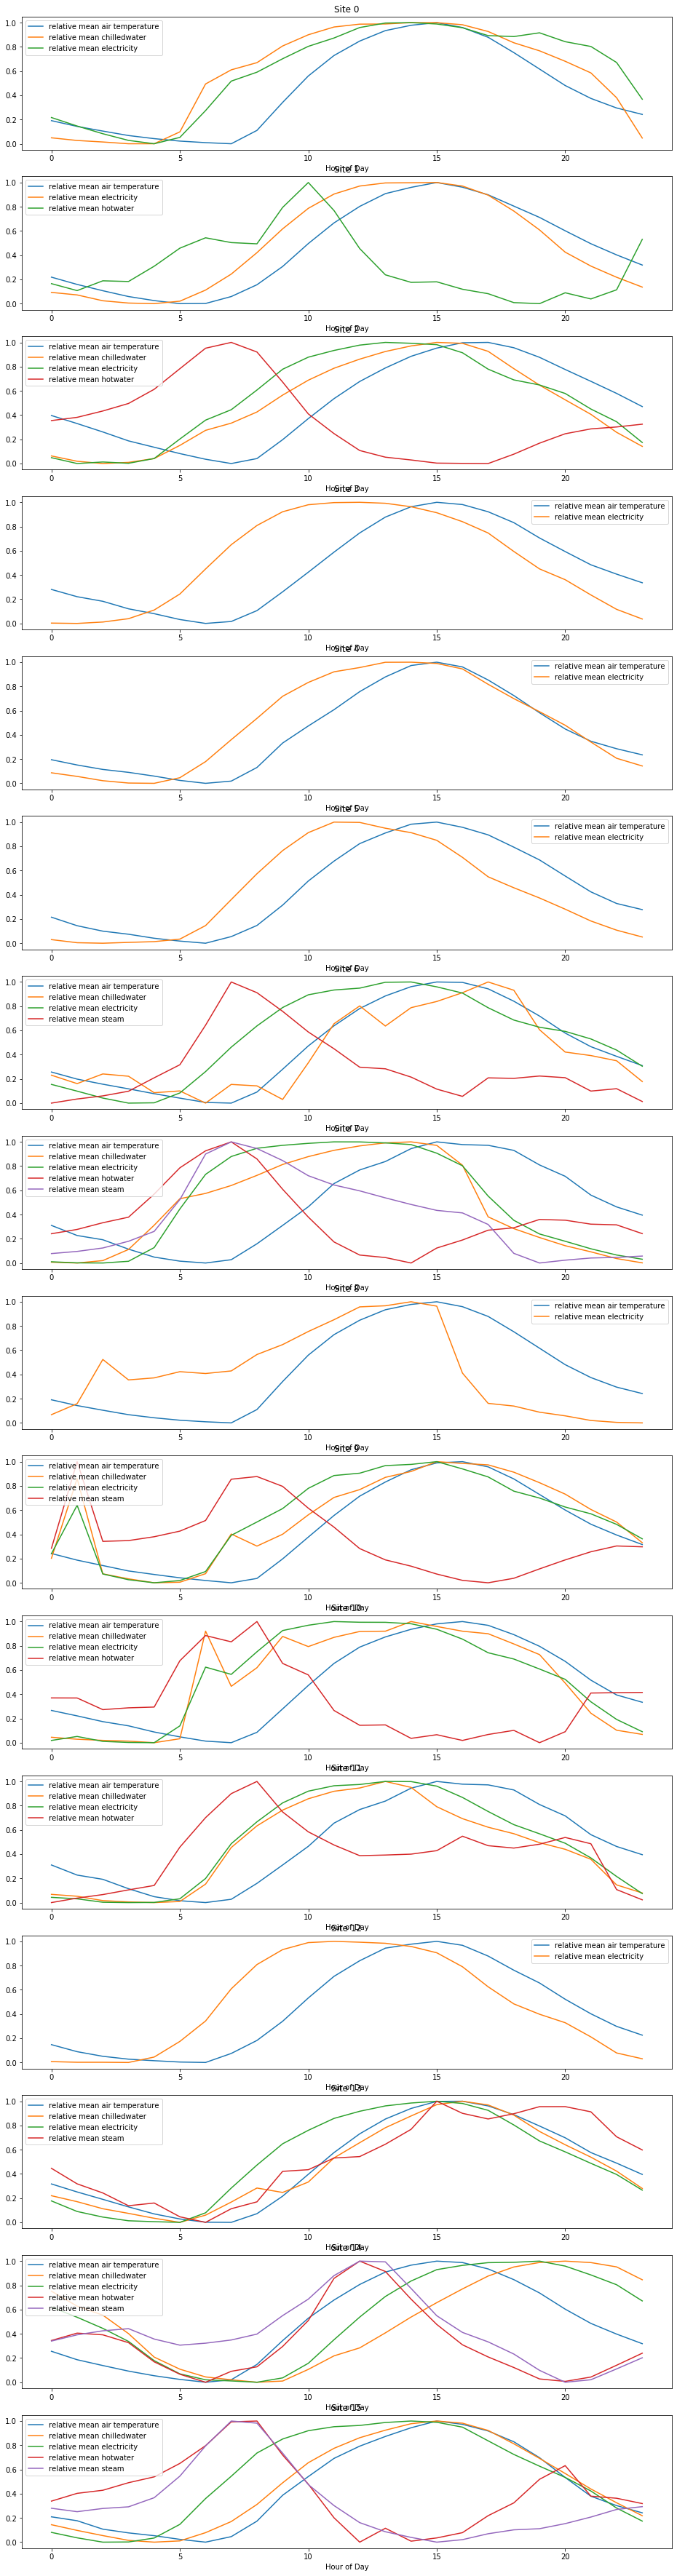

In [11]:
site_count = train_df["site_id"].unique().size
fig, axs = plt.subplots(figsize=(16,64), nrows=site_count)
for (site_id, train_per_site), (site_id, weather_per_site), ax in zip(train_df.groupby(["site_id"]), weather_df.groupby(["site_id"]), axs.flatten()):
    ax.set_title('Site %d'%site_id)
    ax.set_xlabel('Hour of Day')
    mean_air_temperature = weather_per_site.groupby(["local hour"])["air_temperature"].mean()
    ax.plot(relativize(mean_air_temperature, mean_air_temperature.min(), mean_air_temperature.max()), label="relative mean air temperature")
    for meter, per_meter in train_per_site.groupby(["meter"]):
        mean_meter_reading = per_meter.groupby(["hour"])["meter_reading"].mean()
        ax.plot(relativize(mean_meter_reading, mean_meter_reading.min(), mean_meter_reading.max()), label="relative mean " + str(meter))
    ax.legend()

plt.show()